# Variational Autoencoder
This notebook demonstrates how to train a Variational Autoencoder (VAE) on the MNIST dataset. A VAE is a probabilistic take on the autoencoder, a model which takes high dimensional input data and compresses it into a smaller representation. Unlike a traditional autoencoder, which maps the input onto a latent vector, a VAE maps the input data into the parameters of a probability distribution, such as the mean and variance of a Gaussian. This approach produces a continuous, structured latent space, which is useful for image generation.

### Preprocess Helper Function

In [10]:
def preprocess_images(images):
    images = images.reshape((images.shape[0], 28, 28, 1)) / 255.
    return np.where(images > .5, 1.0, 0.0).astype('float32')

## Setup

In [11]:
# !pip install tensorflow-probability
# !pip install imageio
# !pip install git+https://github.com/tensorflow/docs

### Import

In [28]:
import glob
import ssl
import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import tensorflow_probability as tfp
import time
import tensorflow_docs.vis.embed as embed
from IPython import display

### SSL Certificate

In [13]:
ssl._create_default_https_context = ssl._create_unverified_context

### Load the MNIST dataset
Each MNIST image is originally a vector of 784 integers, each of which is between 0-255 and represents the intensity of a pixel. Model each pixel with a Bernoulli distribution in our model, and statically binarize the dataset.

In [14]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

### Parameters

In [15]:
train_size = 60000
batch_size = 32
test_size = 10000

### Preprocess

In [16]:
train_images = preprocess_images(train_images)
test_images = preprocess_images(test_images)

### To Tensorflow Tensors data structures

In [17]:
train_dataset = (tf.data.Dataset.from_tensor_slices(train_images)
                 .shuffle(train_size).batch(batch_size))
test_dataset = (tf.data.Dataset.from_tensor_slices(test_images)
                .shuffle(test_size).batch(batch_size))

Metal device set to: Apple M2


2023-02-08 22:24:22.855059: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-08 22:24:22.855613: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


### Define the encoder and decoder networks with *tf.keras.Sequential*

In this VAE example, use two small ConvNets for the encoder and decoder networks. In the literature, these networks are also referred to as inference/recognition and generative models respectively. Use `tf.keras.Sequential` to simplify implementation. Let $x$ and $z$ denote the observation and latent variable respectively in the following descriptions.

### Encoder network
This defines the approximate posterior distribution $q(z|x)$, which takes as input an observation and outputs a set of parameters for specifying the conditional distribution of the latent representation $z$. 
In this example, simply model the distribution as a diagonal Gaussian, and the network outputs the mean and log-variance parameters of a factorized Gaussian. 
Output log-variance instead of the variance directly for numerical stability.

### Decoder network 
This defines the conditional distribution of the observation $p(x|z)$, which takes a latent sample $z$ as input and outputs the parameters for a conditional distribution of the observation.
Model the latent distribution prior $p(z)$ as a unit Gaussian.

### Network architecture
For the encoder network, use two convolutional layers followed by a fully-connected layer. In the decoder network, mirror this architecture by using a fully-connected layer followed by three convolution transpose layers (a.k.a. deconvolutional layers in some contexts). Note, it's common practice to avoid using batch normalization when training VAEs, since the additional stochasticity due to using mini-batches may aggravate instability on top of the stochasticity from sampling.

In [18]:
class CVAE(tf.keras.Model):
    def __init__(self, latent_dim):
        super(CVAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
            tf.keras.layers.Conv2D(filters=32, 
                                   kernel_size=3, 
                                   strides=(2, 2),
                                   activation='relu'),
            tf.keras.layers.Conv2D(filters=64,
                                   kernel_size=3,
                                   strides=(2, 2),
                                   activation='relu'),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(latent_dim + latent_dim)])
        
        self.decoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(units=7*7*32, activation=tf.nn.relu),
            tf.keras.layers.Reshape(target_shape=(7, 7, 32)),
            tf.keras.layers.Conv2DTranspose(filters=64, 
                                            kernel_size=3, 
                                            strides=2, 
                                            padding='same',
                                            activation='relu'),
            tf.keras.layers.Conv2DTranspose(filters=32, 
                                            kernel_size=3, 
                                            strides=2, 
                                            padding='same',
                                            activation='relu'),
            tf.keras.layers.Conv2DTranspose(filters=1,
                                            kernel_size=3, 
                                            strides=1, 
                                            padding='same')])

    @tf.function
    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(100, self.latent_dim))
        return self.decode(eps, apply_sigmoid=True)

    def encode(self, x):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar
    
    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean
    
    def decode(self, z, apply_sigmoid=False):
        logits = self.decoder(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits

### Define the loss function and the optimizer

In [19]:
optimizer = tf.keras.optimizers.Adam(1e-4)

def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.math.log(2. * np.pi)
    return tf.reduce_sum(-.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),axis=raxis)


def compute_loss(model, x):
    mean, logvar = model.encode(x)
    z = model.reparameterize(mean, logvar)
    x_logit = model.decode(z)
    cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
    logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
    logpz = log_normal_pdf(z, 0., 0.)
    logqz_x = log_normal_pdf(z, mean, logvar)
    return -tf.reduce_mean(logpx_z + logpz - logqz_x)

@tf.function
def train_step(model, x, optimizer):
    print('training step...')
    with tf.GradientTape() as tape:
        loss = compute_loss(model, x)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

## Training

* Start by iterating over the dataset
* During each iteration, pass the image to the encoder to obtain a set of mean and log-variance parameters of the approximate posterior $q(z|x)$
* then apply the *reparameterization trick* to sample from $q(z|x)$
* Finally, pass the reparameterized samples to the decoder to obtain the logits of the generative distribution $p(x|z)$
* Note: Since you use the dataset loaded by keras with 60k datapoints in the training set and 10k datapoints in the test set, our resulting ELBO on the test set is slightly higher than reported results in the literature which uses dynamic binarization of Larochelle's MNIST.

### Generating images

* After training, it is time to generate some images
* Start by sampling a set of latent vectors from the unit Gaussian prior distribution $p(z)$
* The generator will then convert the latent sample $z$ to logits of the observation, giving a distribution $p(x|z)$
* Here, plot the probabilities of Bernoulli distributions


In [20]:
epochs = 10
latent_dim = 2
num_examples_to_generate = 16
random_vector_for_generation = tf.random.normal(shape=[num_examples_to_generate, latent_dim])
model = CVAE(latent_dim)

### Generate and Plot Images

In [21]:
def generate_and_save_images(model, epoch, test_sample):
    
    mean, logvar = model.encode(test_sample)
    z = model.reparameterize(mean, logvar)
    predictions = model.sample(z)
    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [22]:
assert batch_size >= num_examples_to_generate
for test_batch in test_dataset.take(1):
    test_sample = test_batch[0:num_examples_to_generate, :, :, :]

Epoch: 10, Test set ELBO: -158.4661865234375, time elapse for current epoch: 9.622679948806763


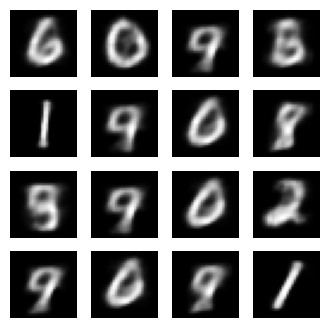

In [23]:
generate_and_save_images(model, 0, test_sample)
for epoch in range(1, epochs + 1):
    start_time = time.time()
    for train_x in train_dataset:
        train_step(model, train_x, optimizer)
    end_time = time.time()
    loss = tf.keras.metrics.Mean()
    for test_x in test_dataset:
        loss(compute_loss(model, test_x))
    elbo = -loss.result()
    display.clear_output(wait=False)
    print('Epoch: {}, Test set ELBO: {}, time elapse for current epoch: {}'
          .format(epoch, elbo, end_time - start_time))
    generate_and_save_images(model, epoch, test_sample)

### Display a generated image from the last training epoch

In [24]:
def display_image(epoch_no):
    return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

(-0.5, 399.5, 399.5, -0.5)

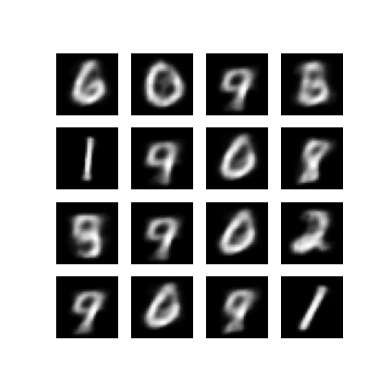

In [25]:
plt.imshow(display_image(epoch))
plt.axis('off')  # Display images

### Display an animated GIF of all the saved images

/var/folders/kg/gffcbs8j5472jdy53thpczsm0000gn/T/ipykernel_43552/2866481235.py:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
/var/folders/kg/gffcbs8j5472jdy53thpczsm0000gn/T/ipykernel_43552/2866481235.py:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)



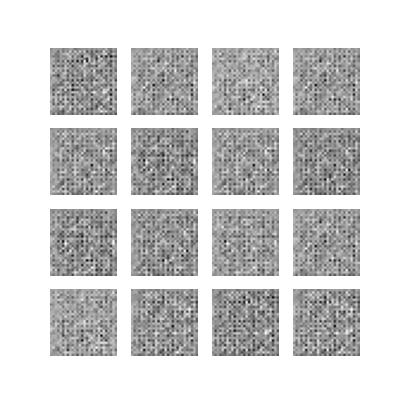

In [26]:
anim_file = 'cvae.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)
embed.embed_file(anim_file)

### Display a 2D manifold of digits from the latent space

Running the code below will show a continuous distribution of the different digit classes, with each digit morphing into another across the 2D latent space. Use [TensorFlow Probability](https://www.tensorflow.org/probability) to generate a standard normal distribution for the latent space.

560
560
(1, 2)
(1, 28, 28, 1)
(1, 2)
(1, 28, 28, 1)
(1, 2)
(1, 28, 28, 1)
(1, 2)
(1, 28, 28, 1)
(1, 2)
(1, 28, 28, 1)
(1, 2)
(1, 28, 28, 1)
(1, 2)
(1, 28, 28, 1)
(1, 2)
(1, 28, 28, 1)
(1, 2)
(1, 28, 28, 1)
(1, 2)
(1, 28, 28, 1)
(1, 2)
(1, 28, 28, 1)
(1, 2)
(1, 28, 28, 1)
(1, 2)
(1, 28, 28, 1)
(1, 2)
(1, 28, 28, 1)
(1, 2)
(1, 28, 28, 1)
(1, 2)
(1, 28, 28, 1)
(1, 2)
(1, 28, 28, 1)
(1, 2)
(1, 28, 28, 1)
(1, 2)
(1, 28, 28, 1)
(1, 2)
(1, 28, 28, 1)
(1, 2)
(1, 28, 28, 1)
(1, 2)
(1, 28, 28, 1)
(1, 2)
(1, 28, 28, 1)
(1, 2)
(1, 28, 28, 1)
(1, 2)
(1, 28, 28, 1)
(1, 2)
(1, 28, 28, 1)
(1, 2)
(1, 28, 28, 1)
(1, 2)
(1, 28, 28, 1)
(1, 2)
(1, 28, 28, 1)
(1, 2)
(1, 28, 28, 1)
(1, 2)
(1, 28, 28, 1)
(1, 2)
(1, 28, 28, 1)
(1, 2)
(1, 28, 28, 1)
(1, 2)
(1, 28, 28, 1)
(1, 2)
(1, 28, 28, 1)
(1, 2)
(1, 28, 28, 1)
(1, 2)
(1, 28, 28, 1)
(1, 2)
(1, 28, 28, 1)
(1, 2)
(1, 28, 28, 1)
(1, 2)
(1, 28, 28, 1)
(1, 2)
(1, 28, 28, 1)
(1, 2)
(1, 28, 28, 1)
(1, 2)
(1, 28, 28, 1)
(1, 2)
(1, 28, 28, 1)
(1, 2)
(1, 28, 28, 1)
(1

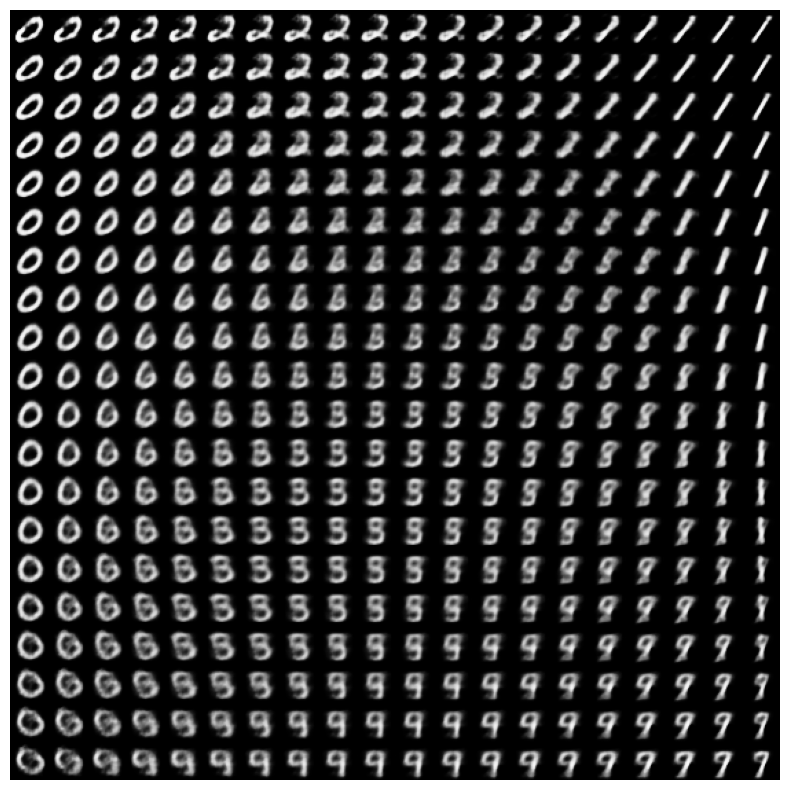

560

In [33]:
def plot_latent_images(model, n, digit_size=28):

    norm = tfp.distributions.Normal(0, 1)
    grid_x = norm.quantile(np.linspace(0.05, 0.95, n))
    grid_y = norm.quantile(np.linspace(0.05, 0.95, n))
    image_width = digit_size*n
    image_height = image_width
    print(image_width)
    print(image_height)    
    image = np.zeros((image_height, image_width))
    for i, yi in enumerate(grid_x):
        for j, xi in enumerate(grid_y):
            z = np.array([[xi, yi]])
            print(z.shape)
            x_decoded = model.sample(z)
            print(x_decoded.shape)
            digit = tf.reshape(x_decoded[0], (digit_size, digit_size))
            image[i * digit_size: (i + 1) * digit_size,
                  j * digit_size: (j + 1) * digit_size] = digit.numpy()

    plt.figure(figsize=(10, 10))
    plt.imshow(image, cmap='Greys_r')
    plt.axis('Off')
    plt.show()
plot_latent_images(model, 20)
20 * 28